In [54]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from math import ceil
from scipy.linalg import sqrtm
from scipy.sparse.linalg import svds
from scipy.sparse import lil_matrix, csr_matrix, diags, issparse

from tqdm import tqdm

## Algorithm

In [55]:
def sample_entry(M, delta):
    
    A = lil_matrix(M.shape, dtype=np.float64)
    
    for i in range(M.shape[1]):
        sample = np.random.choice(2, M.shape[0], p=[1 - delta, delta])
        A[:, i] = (M[:, i] * sample).reshape(-1, 1)

    return A

In [56]:
def SPCA(C, k):
    omega = np.random.randn(C.shape[1], k)
    omega = csr_matrix(omega)
    
    _C = lil_matrix(C.shape)
    
    # Trimming
    for i in range (C.shape[0]):
        if (C.getrow(i).count_nonzero() > 10):
            _C[i, :] = 0
        else:
            _C[i, :] = C[i, :]
    
    _C = _C.tocsr()
    
    diag_matrix = diags(diagonals=((_C.T @ _C).diagonal()), offsets=0, format="csr")
    
    F = _C.T @ _C - diag_matrix
    F = F.todense()
    power = int(np.ceil(5 * np.log(C.shape[1])))
        
    F = np.linalg.matrix_power(F, power)
    F = F @ omega
    Q, _ = np.linalg.qr(F)

    return Q[:, :k]

In [57]:
ram_stat = 0
max_ram = 0
cnt = 0

def get_size(obj):
    if issparse(obj):
        return obj.count_nonzero() * obj.dtype.itemsize
    else:
        return obj.nbytes
    
def ram_stat_init():
    global ram_stat, max_ram, cnt
    
    ram_stat, max_ram, cnt = 0, 0, 0

def ram_stat_alloc(*objs):
    global ram_stat, cnt, max_ram

    for obj in objs:
        s = get_size(obj)
        #print("RAM:", ram_stat + s, "=", ram_stat, "+", s)
        ram_stat += s
        cnt += 1
    
    max_ram = max(ram_stat, max_ram)

def ram_stat_free(*objs):
    global ram_stat, cnt, max_ram

    for obj in objs:
        s = get_size(obj)
        #print("RAM:", ram_stat - obj.nbytes, "=", ram_stat, "-", obj.nbytes)
        ram_stat -= s
        cnt -= 1

In [66]:
ram_stats = []

def SLA(M, k, delta, l):
    global ram_stats
    
    ram_stat_init()

    M = M.astype(np.float64)
    
    m, n = M.shape[0], M.shape[1]
    
    #l_samples = list(np.random.choice(n, l, replace=True))
    l_samples = np.arange(l)
        
    A_b1 = sample_entry(M[:, l_samples], delta).tocsr()
    ram_stat_alloc(A_b1)
    A_b2 = sample_entry(M[:, l_samples], delta)
    ram_stat_alloc(A_b2)
    Q = SPCA(A_b1, k)
    ram_stat_alloc(Q)
    M = np.delete(M, l_samples, 1)
    
    ram_stat_free(A_b2)
    for i in range(m):
        if ((A_b2.getrow(i).count_nonzero()) > 2):
            A_b2[i, :] = 0
            
    for i in range(l):
        if ((A_b2.getcol(i).count_nonzero()) > 10 * delta * m):
            A_b2[:, i] = 0
    ram_stat_alloc(A_b2)
    
    A_b2 = A_b2.tocsr()
    W = A_b2 @ Q
    ram_stat_free(A_b2)
    ram_stat_free(Q)
    ram_stat_alloc(W)
    V = np.zeros((n, k))
    ram_stat_alloc(V)
    
    ram_stat_free(V)
    V[:l, :] = (A_b1).T @ W
    ram_stat_alloc(V)
    I = A_b1 @ V[:l, :]
    ram_stat_alloc(I)
    ram_stat_free(A_b1)
    
    for t in range(l, n):
        A_t = M[:, t - l]
        ram_stat_alloc(A_t)
        ram_stat_free(V)
        V[t, :] = A_t.reshape(1, -1) @ W
        ram_stat_alloc(V)
        ram_stat_free(I)
        I += A_t.reshape(-1, 1) @ V[t, :].reshape(1, -1)
        ram_stat_alloc(I)
        ram_stat_free(A_t)

    ram_stat_free(W)
    
    #print("rank A_b1:", np.linalg.matrix_rank(A_b1))
    #print("rank A_b2:", np.linalg.matrix_rank(A_b2))
    #print("rank W:", np.linalg.matrix_rank(W))
    #print("rank Q:", np.linalg.matrix_rank(Q))
    #print("rank V:", np.linalg.matrix_rank(V))
    #print("rank I:", np.linalg.matrix_rank(I))
    
    R = sqrtm(V.T @ V)
    ram_stat_alloc(R)
    ram_stat_free(R)
    R = np.linalg.inv(R)
    ram_stat_alloc(R)
    
    U = (1.0/delta) * (I @ R @ R.T)
    ram_stat_alloc(U)
    ram_stat_free(R)
    ram_stat_free(I)
    
    M_k = U @ V.T
    
    #print("sizeof(M_k) =", M_k.nbytes)
    ram_stats.append(max_ram)
    print(U.nbytes, V.nbytes)
    
    filler = []
    
    for i in range(n-l-1, n-1):
        filler.append(M_k[:, i])
        filler.append(0.5 * (M_k[:, i] + M_k[:, i+1]))
    
    filler = np.array(filler).T
    
    M_k[:, :n-2*l] = M_k[:, l:n-l]
    M_k[:, n-2*l:] = filler
    
    return M_k      

## Evaluation

## Applications

### 1. Background/Foreground separation

In [67]:
def load_sequence_video(path, start, stop):
    
    files = sorted(os.listdir(path))
    frame = Image.open(os.path.join(path, files[0]))
    frame = frame.convert("L")
    frame = np.array(frame)
    
    frame_size = frame.shape
    size = frame.shape[0] * frame.shape[1]

    M = np.zeros((size, stop - start), np.float32)
    
    for i in range(start, stop):
        frame = Image.open(os.path.join(path, files[i])).convert("L")
        frame = np.array(frame) / 255.0
        M[:, i] = frame.reshape(-1)
    
    return M, frame_size

def display_result_video(M, L, S, n_frames):
    n = M.shape[2]
    lst = np.random.choice(n, n_frames, replace=False)
    
    for i in range(len(lst)):
        plt.figure(figsize=(16, 6))
        
        plt.subplot(1, 3, 1)
        plt.imshow(M[:,:,lst[i]], cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(L[:,:,lst[i]], cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(S[:,:,lst[i]], cmap='gray')
        plt.axis('off')

videos = [
            "./videos/Bootstrap",
            "./videos/Camouflage",
            "./videos/ForegroundAperture",
            "./videos/LightSwitch",
            "./videos/MovedObject",
            "./videos/TimeOfDay",
            "./videos/WavingTrees"
         ]

start = 0
stop = 3050
M_video, frame_size_video = load_sequence_video(videos[0], start, stop)

In [74]:
%%time

delta = 0.05
l = 20
k = 1

n0, m0 = M_video.shape

ss = [None] * 7

for i, s in tqdm(enumerate(range(40, 101, 10))):
    ram_stats = []
    for k in range(1, l + 1):
        n, m = int(n0 * s / 100), int(m0 * s / 100)
        res_video = SLA(M_video[:n, :m].copy(), k, delta, l)
    ss[i] = ram_stats.copy()

0it [00:00, ?it/s]

61440 9760
122880 19520
184320 29280
245760 39040
307200 48800
368640 58560
430080 68320
491520 78080
552960 87840
614400 97600
675840 107360
737280 117120
798720 126880
860160 136640
921600 146400
983040 156160
1044480 165920
1105920 175680
1167360 185440


1it [00:48, 48.98s/it]

1228800 195200
76800 12200
153600 24400
230400 36600
307200 48800
384000 61000
460800 73200
537600 85400
614400 97600
691200 109800
768000 122000
844800 134200
921600 146400
998400 158600
1075200 170800
1152000 183000
1228800 195200
1305600 207400
1382400 219600
1459200 231800


2it [30:52, 575.26s/it]

1536000 244000
92160 14640
184320 29280
276480 43920
368640 58560
460800 73200
552960 87840
645120 102480
737280 117120
829440 131760
921600 146400
1013760 161040
1105920 175680
1198080 190320
1290240 204960
1382400 219600
1474560 234240
1566720 248880
1658880 263520
1751040 278160


3it [32:03, 424.15s/it]

1843200 292800
107520 17080
215040 34160
322560 51240
430080 68320
537600 85400
645120 102480
752640 119560
860160 136640
967680 153720
1075200 170800
1182720 187880
1290240 204960
1397760 222040
1505280 239120
1612800 256200
1720320 273280
1827840 290360
1935360 307440
2042880 324520


4it [33:31, 323.31s/it]

2150400 341600
122880 19520
245760 39040
368640 58560
491520 78080
614400 97600
737280 117120
860160 136640
983040 156160
1105920 175680
1228800 195200
1351680 214720
1474560 234240
1597440 253760
1720320 273280
1843200 292800
1966080 312320
2088960 331840
2211840 351360
2334720 370880


5it [35:15, 257.28s/it]

2457600 390400
138240 21960
276480 43920
414720 65880
552960 87840
691200 109800
829440 131760
967680 153720
1105920 175680
1244160 197640
1382400 219600
1520640 241560
1658880 263520
1797120 285480
1935360 307440
2073600 329400
2211840 351360
2350080 373320
2488320 395280
2626560 417240
2764800 439200


6it [37:16, 216.45s/it]

153600 24400
307200 48800
460800 73200
614400 97600
768000 122000
921600 146400
1075200 170800
1228800 195200
1382400 219600
1536000 244000
1689600 268400
1843200 292800
1996800 317200
2150400 341600
2304000 366000
2457600 390400
2611200 414800
2764800 439200
2918400 463600
3072000 488000


7it [39:36, 193.58s/it]

CPU times: user 16min 8s, sys: 11min 11s, total: 27min 19s
Wall time: 39min 36s


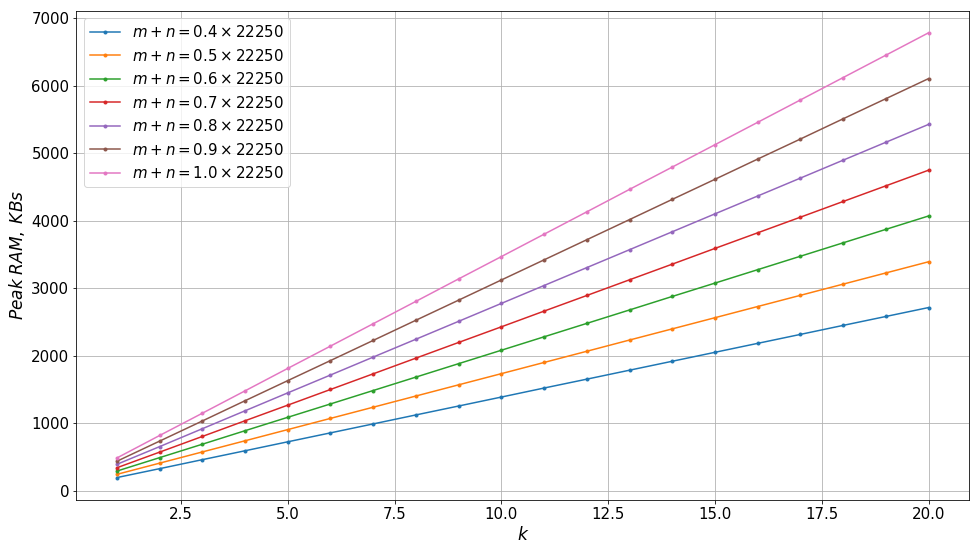

In [106]:
plt.figure(figsize=(16, 9))
#print(ss)
cs = np.array(range(40, 101, 10)) / 100

ks = list(range(1, l + 1))
plt.ylabel(r"$Peak\;RAM,\;KBs$", size=17)
plt.xlabel(r"$k$", size=17)
for i, s in enumerate(ss):
    plt.plot(ks, np.array(s) / 1000, '.-', label=r"$m + n = {0} \times {1}$".format(cs[i], n0 + m0))
plt.grid()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig("ram.png")
plt.show()

In [7]:
print("Approximated matrix rank:", np.linalg.matrix_rank(res_video))

Approximated matrix rank: 1


### Save videos for  separated background and foreground


In [8]:
import os

def save_bmps(dst, M, M_rec, frame_size):
    
    assert M.shape == M_rec.shape

    for j in range(M_rec.shape[1]):
        back_j = M_rec[:, j].reshape(frame_size)
        back_j = back_j / back_j.max()

        orig_j = M[:, j].reshape(frame_size)

        back_j = back_j * 255
        orig_j = orig_j * 255
        fore_j = np.clip(orig_j - back_j, 0, 255)
        
        full_j = np.concatenate([orig_j, back_j, fore_j], axis=1)
        full_j = Image.fromarray(full_j.astype(np.uint8))
        full_j.save(dst + 'b{0:05d}.bmp'.format(j))

In [9]:
path = "./original/"

os.makedirs(path, exist_ok=True)
save_bmps(path, M_video, res_video, frame_size_video)

In [10]:
%%bash

function make_video {
    ffmpeg -v error -framerate 60 -i $1/b0%04d.bmp -r 60 -y $1.mp4
}

for dir in original; do
    make_video $dir
done

In [11]:
M_video_final = M_video.reshape(*frame_size_video, -1)
L_video_final = res_video.reshape(*frame_size_video, -1)
L_video_final = L_video_final / L_video_final.max()
S_video_final = np.maximum(0, M_video_final - L_video_final)
S_video_final[S_video_final < 0.15] = 0

np.count_nonzero(S_video_final) / np.prod(S_video_final.shape)

0.048285382513661206

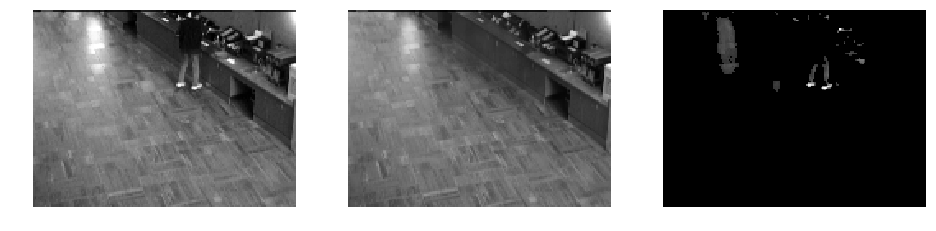

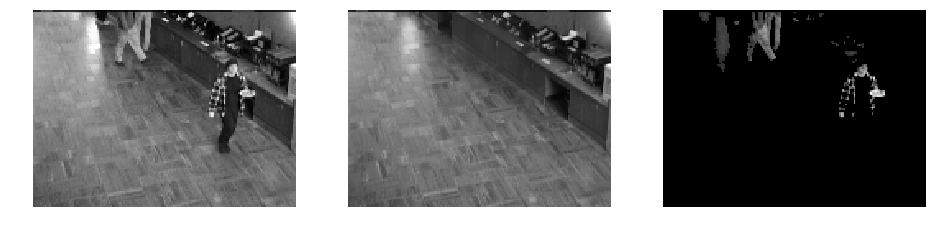

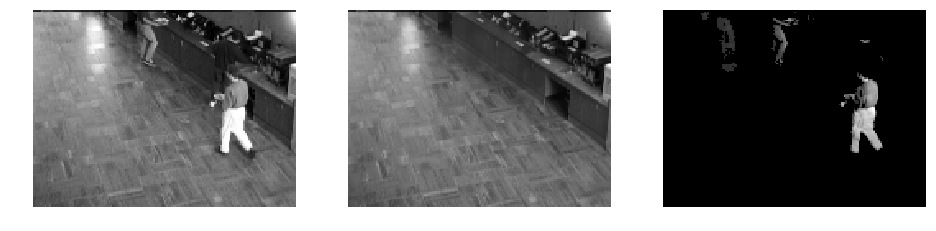

In [12]:
display_result_video(M_video_final,
                     L_video_final,
                     S_video_final, 3)

### 2. Shadow removing

In [13]:
path = "./CroppedYale/yaleB02"

def load_sequence_faces(path):
    files = sorted(os.listdir(path))[-58:]
    frame = Image.open(os.path.join(path, files[25]))

    frame = np.array(frame)
    frame_size = frame.shape
    size = frame.shape[0] * frame.shape[1]

    M = np.zeros((size, len(files)))
    
    for i in range(len(files)):
        frame = Image.open(os.path.join(path, files[i]))
        frame = np.array(frame) / 255.0
        M[:, i] = frame.reshape(-1)
    
    return M, frame_size

M_faces, frame_size_faces = load_sequence_faces(path)

In [14]:
%%time

delta = 0.05
l = 5
k = 1

res_faces = SLA(M_faces.copy(), k, delta, l)

CPU times: user 6.51 s, sys: 64 ms, total: 6.57 s
Wall time: 5.44 s


In [15]:
M_faces_final = M_faces.reshape(*frame_size_faces, -1)
L_faces_final = res_faces.reshape(*frame_size_faces, -1)
L_faces_final = L_faces_final / L_faces_final.max()
S_faces_final = np.maximum(0, M_faces_final - L_faces_final)

In [16]:
def display_result_faces(M, L, S, n_frames):
    n = M.shape[2]
    lst = np.random.choice(n, n_frames, replace=False)
    
    for i in range(len(lst)):
        plt.figure(figsize=(10, 6))
        
        plt.subplot(1, 2, 1)
        plt.imshow(M[:,:,lst[i]], cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(L[:,:,lst[i]], cmap='gray')
        plt.axis('off')

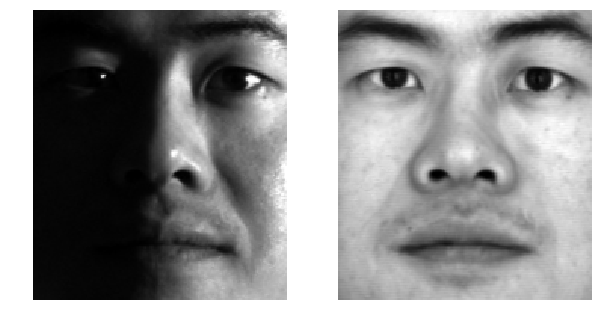

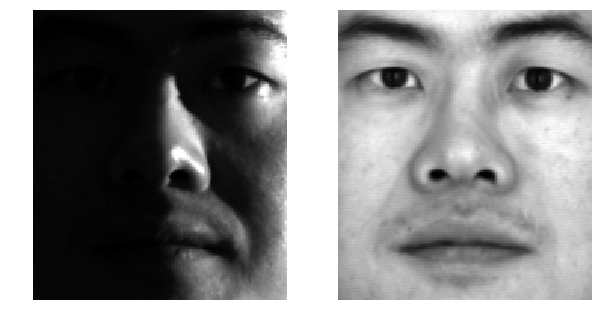

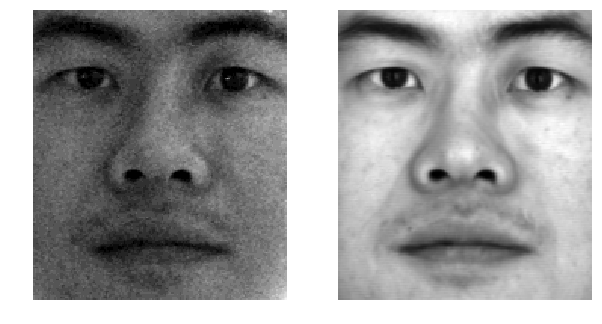

In [17]:
display_result_faces(M_faces_final,
                     L_faces_final,
                     S_faces_final, 3)